In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import wilcoxon, mannwhitneyu
import itertools

In [3]:
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/General_functions/')
from plotting import global_palette
global_palette['Baseline'] = global_palette['linear']
global_palette['DEBIAS-M'] = global_palette['debias-m']

In [4]:
%%time
dfs=pd.read_csv('all-S6-simulation-results-final.csv', index_col=0)
dfs=dfs.loc[dfs.Micro_noise==0]
tm = pd.read_csv('all-micro-noise-simulation-results-final.csv', index_col=0)
tm=tm.loc[tm.Micro_noise>0]
dfs=pd.concat([dfs, tm])
dfs=dfs.loc[dfs.Group.isin(['DEBIAS-M', 'Baseline'])]
dfs=dfs.loc[dfs.is_test_set]

CPU times: user 207 ms, sys: 52.9 ms, total: 260 ms
Wall time: 316 ms


In [5]:
dfs=dfs.loc[dfs.Micro_noise < 0.1]

In [7]:
dfs = dfs.loc[dfs.Pheno_noise > 0]
default_vals = pd.DataFrame({'N_studies':4., 
                             'Pheno_noise':0.1, 
                             'Read_depth':1e4, 
                             'N_features':1e2, 
                             'N_per_study':96, 
                             'Micro_noise':0.
                             }, 
                            index=[0]
                           )

cols_of_interest=default_vals.columns

   sig_v_debias  N_studies     Group
0  6.169081e-06        2.0  Baseline
1  4.172325e-07        3.0  Baseline
2  8.940697e-08        4.0  Baseline
DEBIAS-M N_studies 2.0 vs 3.0 p: 8.1e-02
DEBIAS-M N_studies 2.0 vs 4.0 p: 1.8e-03
DEBIAS-M N_studies 3.0 vs 4.0 p: 6.5e-02


   sig_v_debias  Pheno_noise     Group
0  8.940697e-08          0.1  Baseline
1  1.490116e-07          1.0  Baseline
2  2.980232e-07         10.0  Baseline
DEBIAS-M Pheno_noise 0.1 vs 1.0 p: 2.7e-01
DEBIAS-M Pheno_noise 0.1 vs 10.0 p: 2.0e-01
DEBIAS-M Pheno_noise 1.0 vs 10.0 p: 3.3e-01


   sig_v_debias  Read_depth     Group
0  8.940697e-08      1000.0  Baseline
1  8.940697e-08     10000.0  Baseline
2  8.940697e-08    100000.0  Baseline
DEBIAS-M Read_depth 1000.0 vs 10000.0 p: 3.1e-01
DEBIAS-M Read_depth 1000.0 vs 100000.0 p: 3.1e-01
DEBIAS-M Read_depth 10000.0 vs 100000.0 p: 4.2e-01


   sig_v_debias  N_features     Group
0  8.940697e-08        10.0  Baseline
1  8.940697e-08       100.0  Baseline
DEBIAS-M N_features 

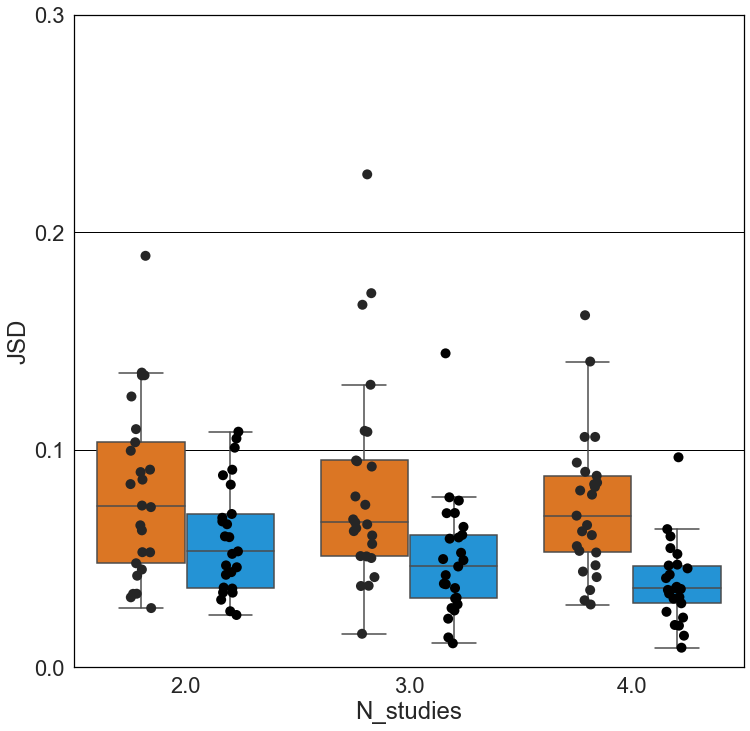

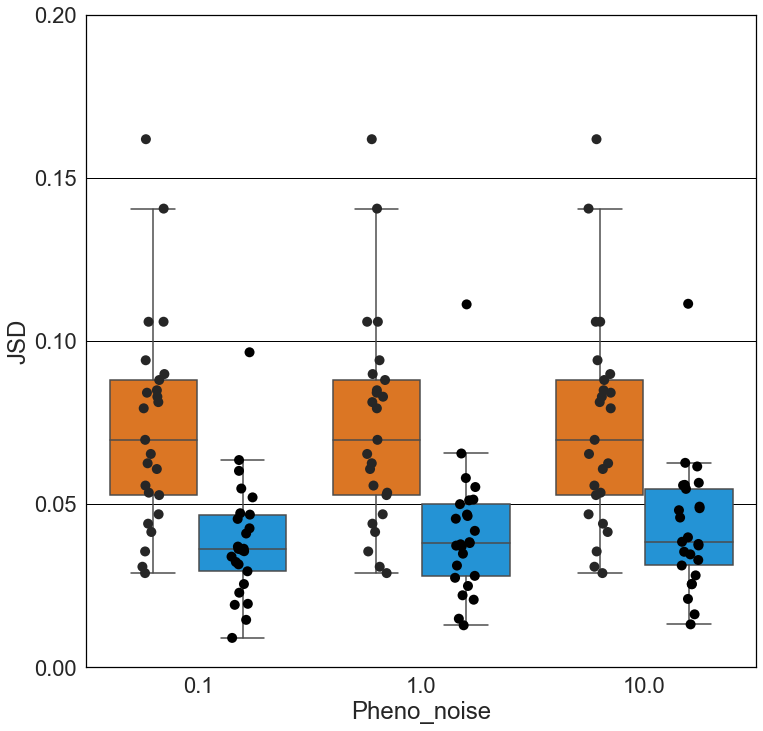

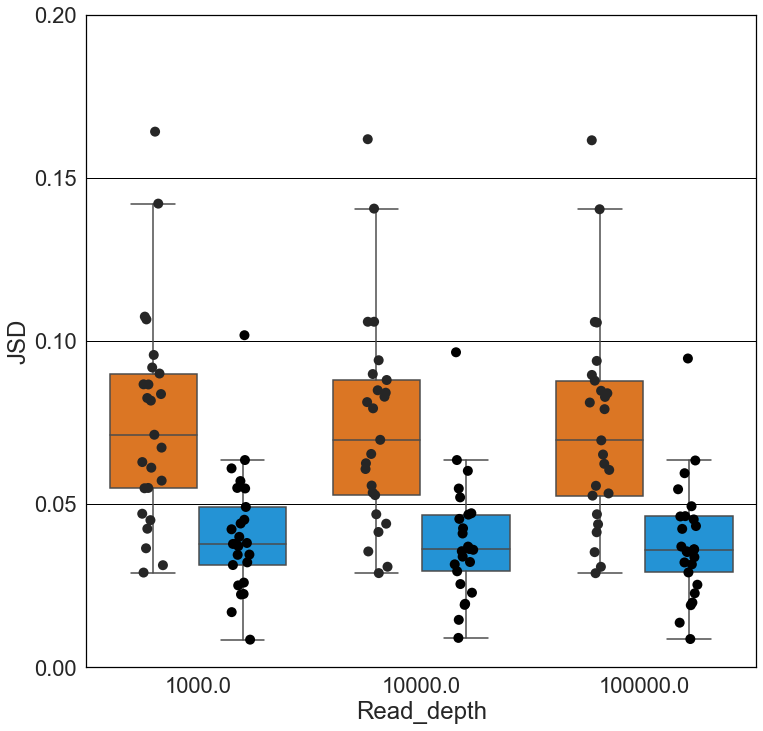

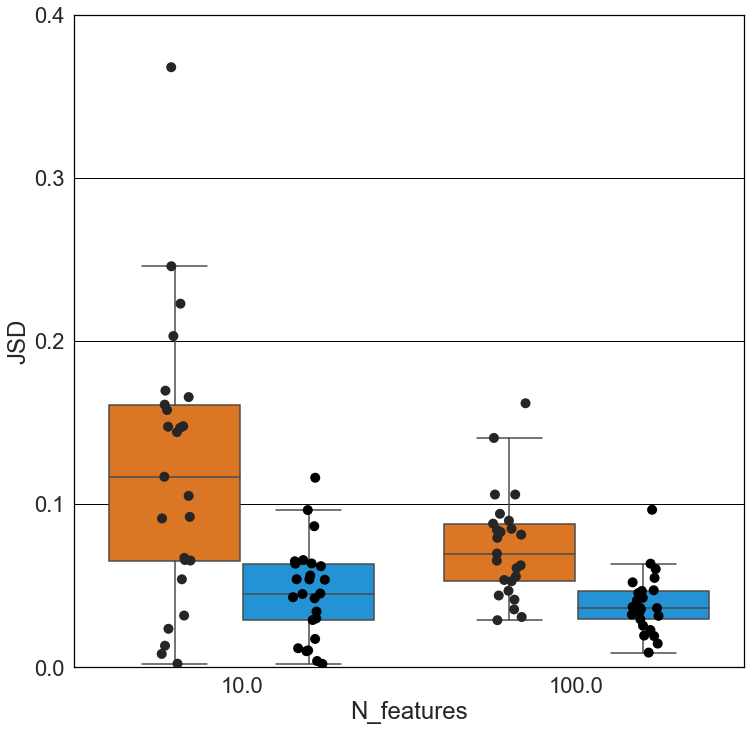

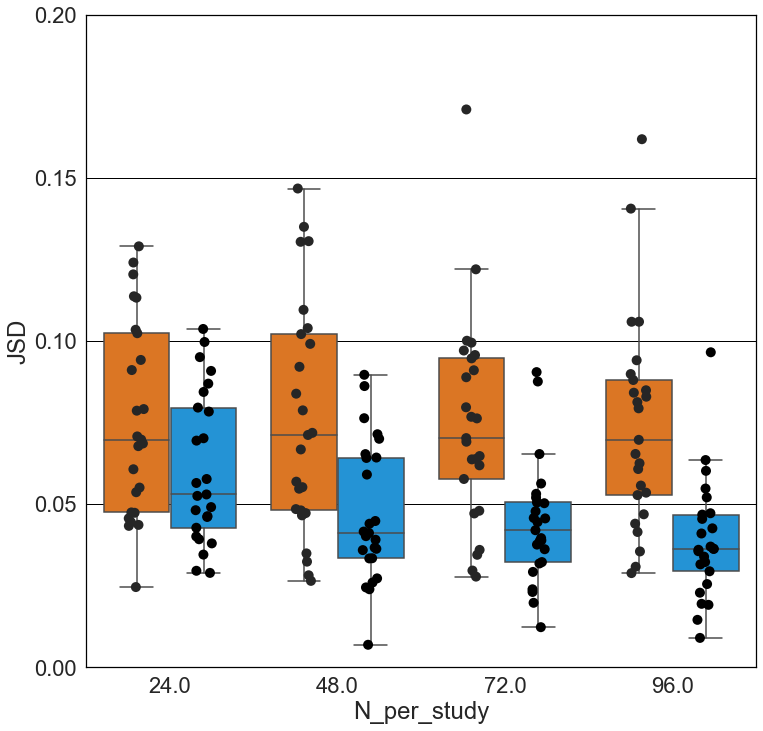

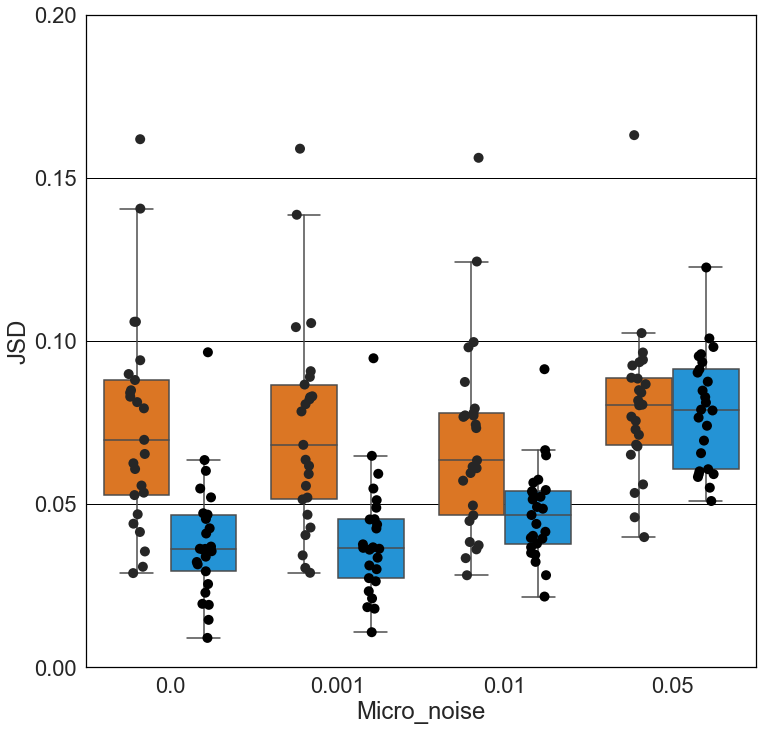

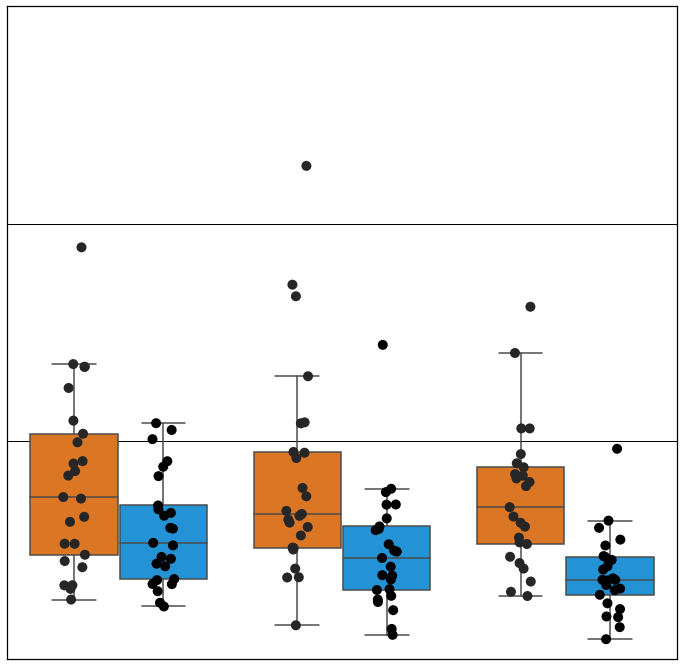

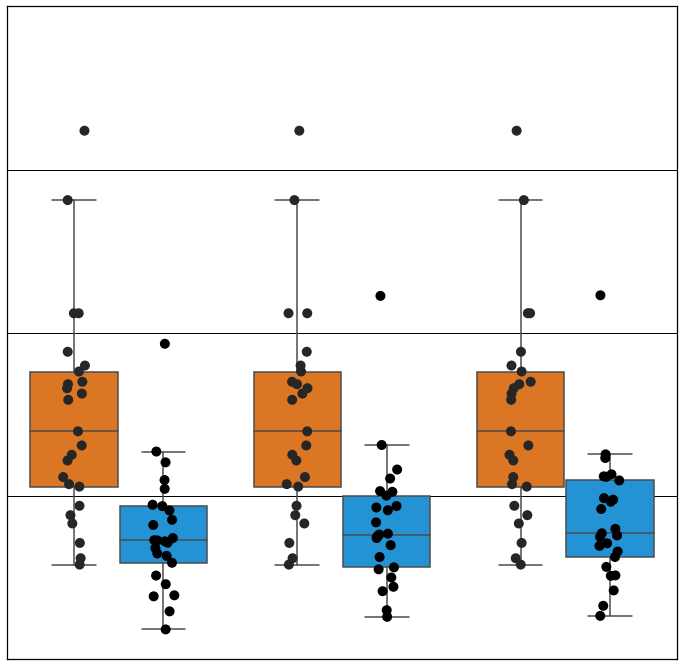

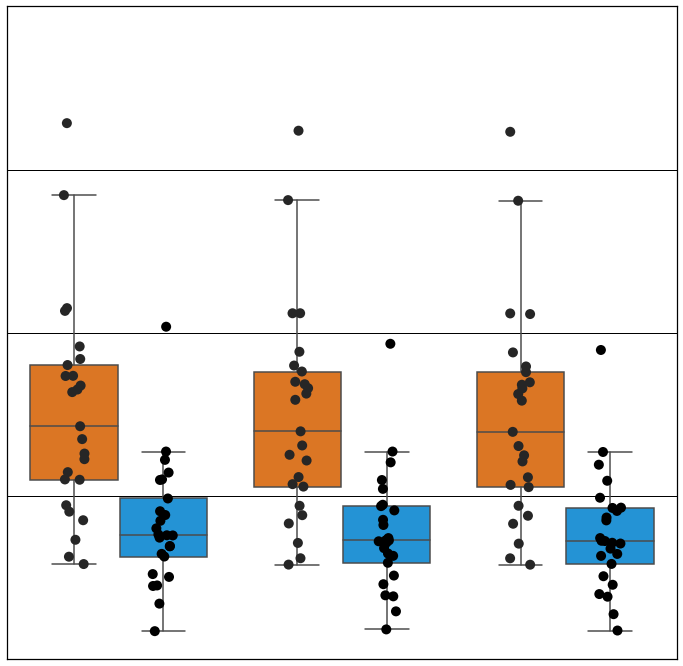

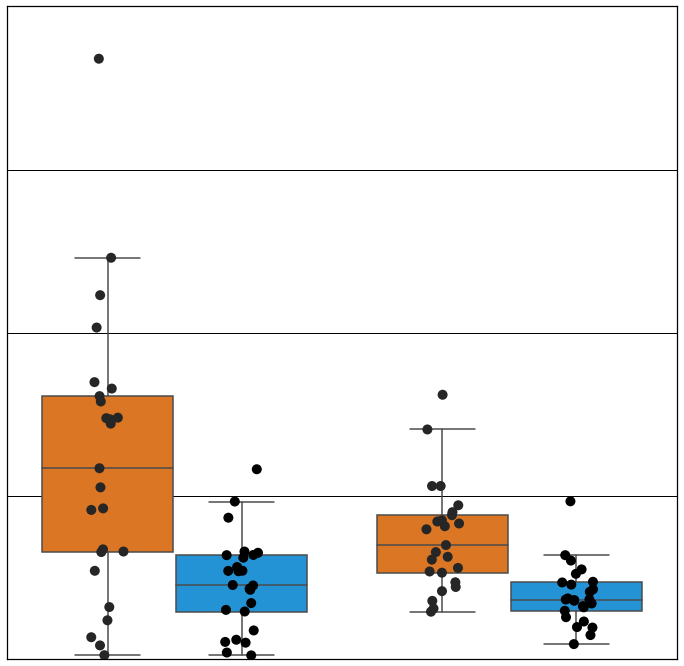

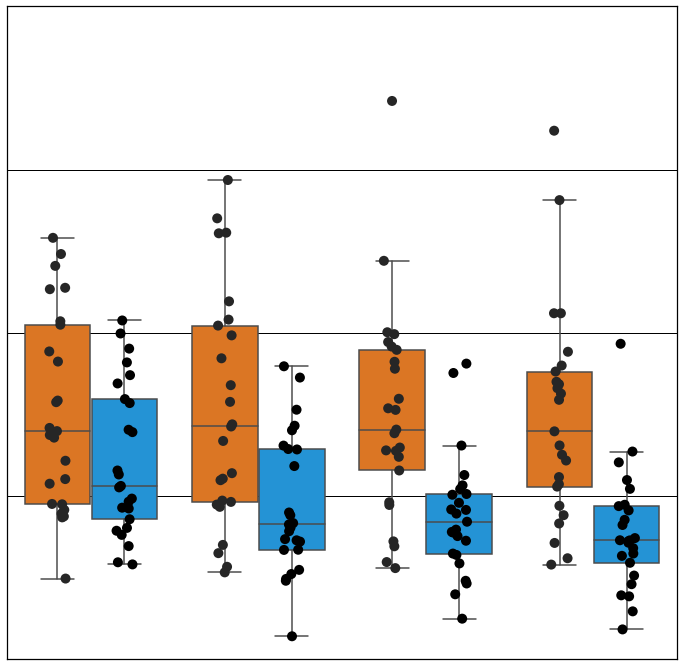

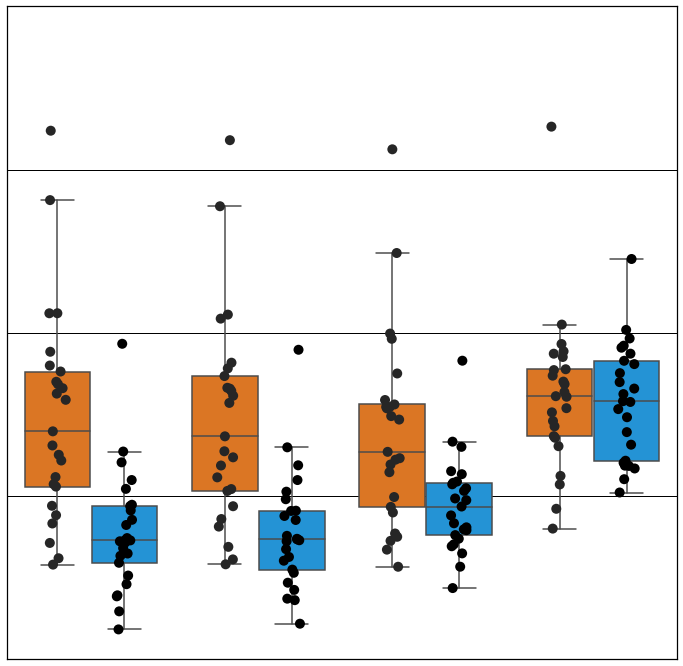

In [81]:
for hide_axes in [False, True]:
    for col_of_interest in default_vals.columns:

        df_tmp = dfs.merge(default_vals.drop(col_of_interest, axis=1))

        df_tmp = df_tmp.groupby( list( df_tmp.columns.drop('JSD').values) 
                                   )['JSD'].median().reset_index()

        plt.figure(figsize=(12, 12))
        # plt.semilogy()
        ax=sns.boxplot(hue='Group', 
                    x = col_of_interest,
                    y = 'JSD', 
                    data=df_tmp, 
                    palette=global_palette,
                    fliersize=0)
        # plt.show()

        sns.stripplot(hue ='Group', 
                      x = col_of_interest,
                      y = 'JSD', 
                      data=df_tmp, 
                      color='black',
                      s=10, 
                      ax=ax, 
                      dodge=True
                      )




        q = pd.DataFrame( {'sig_v_debias':  [ wilcoxon( df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                     ( df_tmp['Group'] == 'Baseline' )].JSD, 
                            df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                       ( df_tmp['Group'] == 'DEBIAS-M' )].JSD, 
                                     alternative='greater'
                          ).pvalue < 1e-3
                           for a in df_tmp[col_of_interest].unique() ], 
                         col_of_interest:df_tmp[col_of_interest].unique(), 
                       'Group':['Baseline'] * df_tmp[col_of_interest].nunique()
                            }
                    )
        
        
        print(pd.DataFrame( {'sig_v_debias':  [ wilcoxon( df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                     ( df_tmp['Group'] == 'Baseline' )].JSD, 
                            df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                       ( df_tmp['Group'] == 'DEBIAS-M' )].JSD, 
                                     alternative='greater'
                          ).pvalue
                           for a in df_tmp[col_of_interest].unique() ], 
                         col_of_interest:df_tmp[col_of_interest].unique(), 
                       'Group':['Baseline'] * df_tmp[col_of_interest].nunique()
                            }
                    ))
        
        
        for a,b in itertools.combinations(df_tmp[col_of_interest].unique(), 2):
            print('DEBIAS-M {} {} vs {} p: {:.1e}'.format(
                                            col_of_interest,
                                            a, 
                                            b,  
                        mannwhitneyu(df_tmp.loc[(df_tmp.Group=='DEBIAS-M')&\
                                          (df_tmp[col_of_interest]==a)].JSD, 
                               df_tmp.loc[(df_tmp.Group=='DEBIAS-M')&\
                                          (df_tmp[col_of_interest]==b)].JSD ).pvalue
                 ))
        print('\n')

        plt.ylabel('JSD')
        plt.legend().remove()
        if np.min(df_tmp.JSD < 0.2):
            plt.ylim(0, 0.2)
            ax.set(yticks=np.linspace(0, 0.2, 5),
                  )
        else:
            plt.ylim(0, .4)
            ax.set(yticks=[0,.1, .2, .3, .4])
            
            if np.min(df_tmp.JSD < 0.25):
                plt.ylim(0, .3)
                ax.set(yticks=[0,.1, .2, .3])
        
        out_path = '../results/Fig-3-gut/JSD-plot-{}.pdf'.format(col_of_interest)
        if hide_axes:
            ax.set_xticks([])
            ax.set(#yticks=np.linspace(0, 0.2, 5),
                   yticklabels=[])
            plt.xlabel(None)
            plt.ylabel(None)
            plt.title(None)
            plt.savefig(out_path[:-4] + '-no-axes'+out_path[-4:], 
                        dpi=900,
                        bbox_inches='tight', 
                        format='pdf')

        else:
            plt.savefig(out_path, 
                        dpi=900,
                       bbox_inches='tight', 
                       format='pdf')